# Machine Learning in TensorFlow and Keras

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2025-fall-main/blob/master/assignment/a1/TensorFlow.ipynb)

### Brief Review of Machine Learning

In supervised learning, parametric models are those where the model is a function of a fixed form with a number of unknown _parameters_.  Together with a loss function and a training set, an optimizer can select parameters to minimize the loss with respect to the training set.  Common optimizers include stochastic gradient descent.  It tweaks the parameters slightly to move the loss "downhill" due to a small batch of examples from the training set.

### Linear & Logistic Regression

You've likely seen linear regression before.  In linear regression, we fit a line (technically, hyperplane) that predicts a target variable, $y$, based on some features $x$.  The form of this model is affine (even if we call it "linear"):  

$$y_{hat} = xW + b$$

where $W$ and $b$ are weights and an offset, respectively, and are the parameters of this parametric model.  The loss function that the optimizer uses to fit these parameters is the squared error ($||\cdots||_2$) between the prediction and the ground truth in the training set.

You've also likely seen logistic regression, which is tightly related to linear regression.  Logistic regression also fits a line - this time separating the positive and negative examples of a binary classifier.  The form of this model is similar:

$$y_{hat} = \sigma(xW + b)$$

where again $W$ and $b$ are the parameters of this model, and $\sigma$ is the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) which maps un-normalized scores ("logits") to values $\hat{y} \in [0,1]$ that represent probabilities. The loss function that the optimizer uses to fit these parameters is the [cross entropy](../../materials/lesson_notebook/lesson_1_NN_Review.ipynb) between the prediction and the ground truth in the training set.

This pattern of an affine transform, $xW + b$, occurs over and over in machine learning.

### Preliminaries...

Before we do anything else, let's load our data and take a quick look at it.  In this example, we're going to build a (very) simple binary classifier based on two floating point features.

In [5]:
np.random.permutation(5)

array([3, 2, 0, 4, 1])

In [ ]:
import numpy as np

def generate_data(num_train, num_test):
    """
    Generate a simple 2D binary classification dataset (linearly separable).

    Parameters
    ----------
    num_train : int
        Number of training examples to return.
    num_test : int
        Number of testing examples to return.

    Returns
    -------
    X_train : ndarray of shape (num_train, 2)
        Training input features (2D points).
    y_train : ndarray of shape (num_train,)
        Training labels (0 or 1).
    X_test : ndarray of shape (num_test, 2)
        Testing input features.
    y_test : ndarray of shape (num_test,)
        Testing labels.
    """
    np.random.seed(1)                      # Ensure reproducibility
    num = num_train + num_test             # Total examples per class

    # Generate Gaussian blobs for class 0 and class 1
    x0 = np.random.randn(num, 2) + 3.*np.array([1, 0])   # class 0, shifted right
    x1 = np.random.randn(num, 2) + 1.*np.array([-1, 0])  # class 1, shifted left

    # Stack data vertically: total 2*num points
    X = np.vstack([x0, x1]) # shape = (2*num, 2)

    # Create corresponding labels: first num are 0, next num are 1
    y = np.concatenate([np.zeros(num), np.ones(num)]) # shape = (2*num,)

    # Shuffle the dataset so classes are mixed
    shuf_idx = np.random.permutation(len(y))
    X = X[shuf_idx]
    y = y[shuf_idx]

    # Split into train/test partitions
    return X[:num_train], y[:num_train], X[num_train:num], y[num_train:num] # leave out 1*num unused


def generate_non_linear_data(num_train, num_test):
    """
    Generate a more complex 2D dataset (non-linear, 4 clusters total).

    Parameters
    ----------
    num_train : int
        Number of training examples to return.
    num_test : int
        Number of testing examples to return.

    Returns
    -------
    X_train : ndarray of shape (num_train, 2)
        Training input features (2D points).
    y_train : ndarray of shape (num_train,)
        Training labels (0 or 1).
    X_test : ndarray of shape (num_test, 2)
        Testing input features.
    y_test : ndarray of shape (num_test,)
        Testing labels.
    """
    np.random.seed(1)                      # Ensure reproducibility
    num = num_train + num_test             # Total examples per cluster

    # Generate 4 Gaussian blobs:
    x0 = np.random.randn(num, 2) + 4.*np.array([1, 0])    # class 0, right
    x1 = np.random.randn(num, 2) + 4.*np.array([0, 1])    # class 1, up
    x2 = np.random.randn(num, 2) + 4.*np.array([-1, 0])   # class 0, left
    x3 = np.random.randn(num, 2) + 4.*np.array([0, -2])   # class 1, down

    # Combine all clusters, total 4*num points
    X = np.vstack([x0, x1, x2, x3])

    # Labels: x0 + x2 → class 0; x1 + x3 → class 1
    y = np.concatenate([
        np.zeros(num), np.ones(num),
        np.zeros(num), np.ones(num)
    ])

    # Shuffle the dataset
    shuf_idx = np.random.permutation(len(y))
    X = X[shuf_idx]
    y = y[shuf_idx]

    # Split into train/test, we are only returning 1*num here.
    return X[:num_train], y[:num_train], X[num_train:num], y[num_train:num]


In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

(2500, 2)
(500, 2)


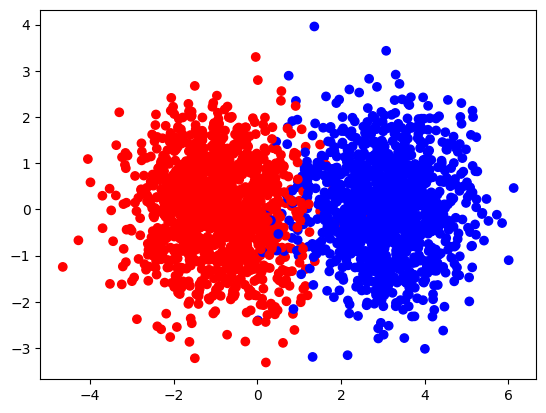

In [15]:
X_train, y_train, X_test, y_test = generate_data(2500, 500) #large test size to make diagrams better
print(X_train.shape)
print(X_test.shape)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='bwr');

### Training Logistic Regression

It's clear that the data is separable with a vertical line.  The simplest model we can use for this data is logistic regression.  Let's do that.

In [16]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.19.1


In [ ]:
# Sanity check
y_train.mean()

0.5124

In [18]:
#####
## MAKE SURE YOU UNDERSTAND THIS CODE!!
##
## Look up keras.Sequential and keras.layers.Dense!
##
## You will need to use them to write your own model down below!
#####

# Sequential models are ones where the set of specified layers are stacked each on top of the previous.
linear_model = keras.Sequential([
    keras.layers.Dense(1, input_shape=(2,), activation='sigmoid')
])

# adam optimizer is a fancier version of gradient descent.  You can read more about it here: https://arxiv.org/pdf/1412.6980.pdf
linear_model.compile(optimizer='adam',
              loss='binary_crossentropy',  # From information theory notebooks.
              metrics=['accuracy'])        # What metric to output as we train.

linear_model.fit(X_train, y_train, epochs=15)

Epoch 1/15


/share/crsp/lab/pkaiser/ddlin/mids/datasci-266/2025-fall-main/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1628 - loss: 1.6108
Epoch 2/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1716 - loss: 1.4766
Epoch 3/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1848 - loss: 1.3490 
Epoch 4/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1996 - loss: 1.2304
Epoch 5/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2208 - loss: 1.1205
Epoch 6/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2488 - loss: 1.0192
Epoch 7/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2904 - loss: 0.9279
Epoch 8/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3436 - loss: 0.8458
Epoch 9/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4208 - loss: 0.7727
Epoch 10/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5192 - loss: 0.7073
Epoch 11/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6216 - loss: 0.6495
Epoch 12/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7268 - loss: 0.5986

**Hint:** You should expect to see an initial loss here of 0.2 - 1.2.  This is because a well-initialized random classifier tends to output a uniform distribution.  For each example in the batch, we either compute the cross-entropy loss of the label (`[1, 0]` or `[0, 1]`) against the model's output (`~[0.5, 0.5]`).  Both cases result in $-\lg(0.5) = lg(2) = 1.0$.

Of course, your random classifier won't output exactly uniform distributions (it's random after all), but you should anticipate it being pretty close.  If it's not, your initialization may be broken and make it hard for your network to learn.

**[Optional]** Some technical details... if your randomly initialized network is outputting very confident predictions, the loss computed may be very large while at the same time the sigmoids in the network are likely in saturation, quickly shrinking gradients.  The result is that you make tiny updates in the face of a huge loss.

Let's use our model to make predictions on the test set:

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


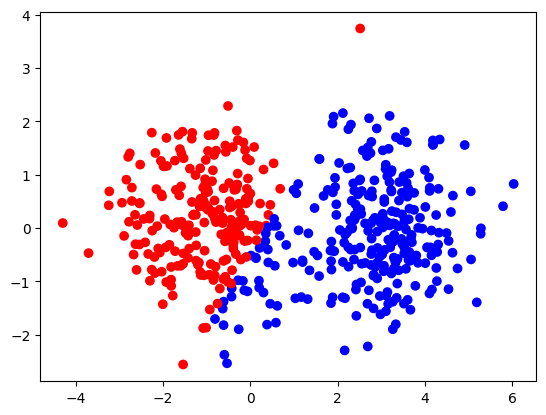

In [ ]:
# model.predict outputs probabilities for each class.
predictions = linear_model.predict(X_test)

# Make a scatter plot of the two input features in X_test.
# - X_test[:,0] are the x-axis values (feature 1).
# - X_test[:,1] are the y-axis values (feature 2).
# - c=predictions[:,0]>0.5 means: color each point red/blue depending on
#   whether the predicted probability is greater than 0.5 (True → one class, False → the other).
# - cmap='bwr' applies a blue-white-red colormap for the binary classes.

plt.scatter(X_test[:,0], X_test[:,1], c=predictions[:,0]>0.5, cmap='bwr')

### But what about a harder problem?

The case above, the data was linearly separable making it susceptible to a linear classifier.

But what if you had data that looked more like this?

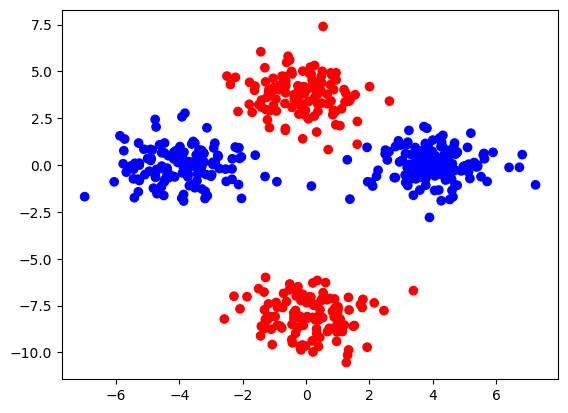

In [22]:
X_train, y_train, X_test, y_test = generate_non_linear_data(2500, 500)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='bwr')

In [23]:
linear_model.fit(X_train, y_train, epochs=10)

Epoch 1/10
 1/79 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4688 - loss: 0.9526

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5076 - loss: 0.8560
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5800 - loss: 0.7417
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5368 - loss: 0.7159 
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5172 - loss: 0.7014
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5092 - loss: 0.6909
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5052 - loss: 0.6831
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5048 - loss: 0.6776
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5060 - loss: 0.6737
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5116 - loss: 0.6713
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5180 - loss: 0.6695


Again, let's make predictions on the test set...

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


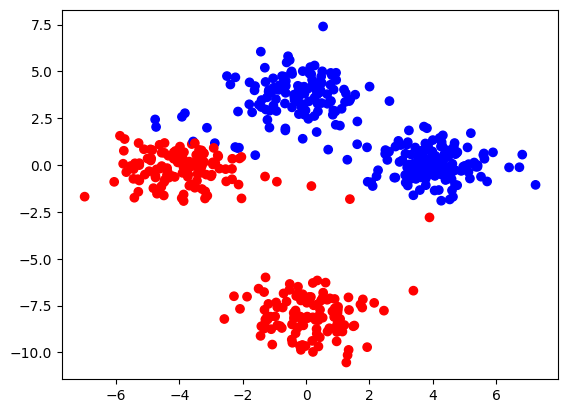

In [24]:
predictions = linear_model.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=predictions[:,0]>0.5, cmap='bwr')

That isn't very good!

### Building a deeper network with the Sequential API

Ok, now it's your turn.  Build a sequential neural network below and start to build intuition around the effects of the number of layers in the network and the number of neurons in each layer.  Try to achieve a loss less than 0.05.  Initialization is random, but try to make it happen "almost" always (e.g. at least 90% of the time). Let's look first at the number of layers.

In [ ]:
deep_model = keras.Sequential([
    #
    # Hint, try "relu" as your activation function.
    # relu(z) = max(0, z).
    #     Note that: relu(z) = z when z > 0
    #                relu(z) = 0 otherwise
    #
    # See https://en.wikipedia.org/wiki/File:Ramp_function.svg
    #
    # This is the most common nonlinearity for the main body of the network as its derivative is
    # either 0 or 1, depending on the value of z.
    #
    # This means that the gradient doesn't tend to explode or vanish as you multiply more partial
    # derivative terms together.
    #
    # For this problem...
    #
    # Try toying with the trade offs between more layers vs wider networks:
    #   If we keep repeating the same hidden layer with n neurons:
    #    What's the minimum number of hidden layers you can get away with given a larger value of n?
    #    For this exercise the value of n should be constant across all your layers and n > 5

    keras.layers.Dense(8, input_shape=(2,), activation='relu'),
    keras.layers.Dense(8, activation='relu'),

    # Think about why you still use a sigmoid at the top of your network.
    keras.layers.Dense(1, activation='sigmoid')
])

deep_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

deep_model.fit(X_train, y_train, epochs=10)

Epoch 1/10


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7324 - loss: 0.6044
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7404 - loss: 0.4489
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8416 - loss: 0.3562
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.2017
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0923
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0476
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0297
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0217
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0169
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0143


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


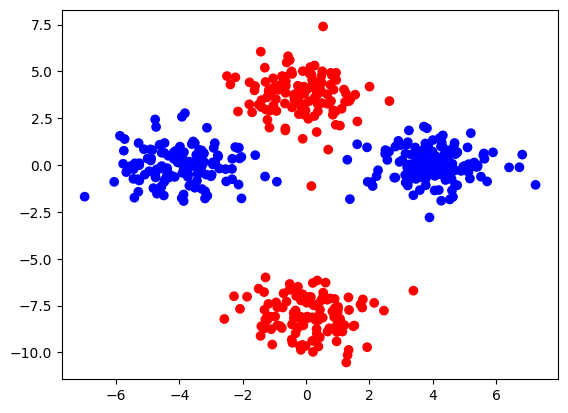

In [60]:
predictions = deep_model.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=predictions[:,0]>0.5, cmap='bwr')

**Question 4**: What is the minimum number of hidden layers with the same number of neurons in each you can get away with and still achieve the desired loss on the training set?  Enter your answer in the answers file.

    - 1 hidden layers with 8 neurons

In [118]:
num_neurons = 5

narrow_model = keras.Sequential([
    #
    # Hint, try "relu" as your activation function.
    # relu(z) = max(0, z).
    #     Note that: relu(z) = z when z > 0
    #                relu(z) = 0 otherwise
    #
    # See https://en.wikipedia.org/wiki/File:Ramp_function.svg
    #
    # This is the most common nonlinearity for the main body of the network as its derivative is
    # either 0 or 1, depending on the value of z.
    #
    # This means that the gradient doesn't tend to explode or vanish as you multiply more partial
    # derivative terms together.
    #
    # For this problem...
    #
    # Try toying with the trade offs between more layers vs wider networks:
    #   If we keep repeating the same hidden layer with n neurons:
    #    What's the smallest number of neurons (n) in each layer you can use
    #     if you use four or more layers?

    keras.layers.Dense(num_neurons, input_shape=(2,), activation='relu'),
    keras.layers.Dense(num_neurons, activation='relu'),
    keras.layers.Dense(num_neurons, activation='relu'),
    keras.layers.Dense(num_neurons, activation='relu'),
    keras.layers.Dense(num_neurons, activation='relu'),
    keras.layers.Dense(num_neurons, activation='relu'),
    keras.layers.Dense(num_neurons, activation='relu'),
    # keras.layers.Dense(num_neurons, activation='relu'),
    # keras.layers.Dense(num_neurons, activation='relu'),
    # keras.layers.Dense(num_neurons, activation='relu'),
    # keras.layers.Dense(num_neurons, activation='relu'),
    # keras.layers.Dense(num_neurons, activation='relu'),

    # Think about why you still use a sigmoid at the top of your network.
    keras.layers.Dense(1, activation='sigmoid')
])

narrow_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

narrow_model.fit(X_train, y_train, epochs=10)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7636 - loss: 0.6816
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8736 - loss: 0.5790
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9660 - loss: 0.3659
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.1721
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0702
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0348
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0246
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0206
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0184
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0171


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


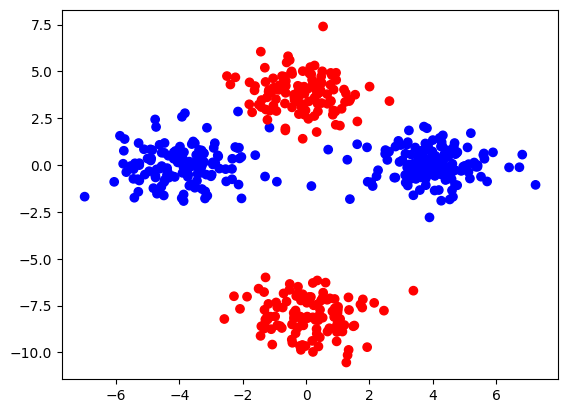

In [99]:
n_predictions = narrow_model.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=n_predictions[:,0]>0.5, cmap='bwr')

**Question 5**: What is the smallest number of neurons you can use in a layer in the network with the largest number of layers and still get the desired loss on the training set?

    - 5 neurons

### Keras Functional API

Finally, let's do some initial exploration of the Keras Functional API. The code above used a Sequential model, which is a simplified way to create a Tensorflow model using Keras. As you can see above, we can build a Sequential model just by listing some layers, which Keras will attach one after the other. If we want to do anything fancier, though, like have multiple inputs or outputs, we need to use the Functional API.

Let's imagine that we want to take the input features we used above, but now we want to pass the same input into two separate Dense layers, then compare the vectors that come out of them. There isn't a practical reason to do this right now, we're just getting familiar with some more Keras layer operations, that you might use in the future when you do have a reason (e.g. if you have two different types of input or you want to generate multiple different outputs).

With the Functional API, we first instantiate each layer, specifying any parameters like the dimension (number of neurons). Then, we "call" the layer we just created, using another set of parentheses to pass in whatever the input to that layer is. That's how we connect the layers, we save the output from one layer and then pass it as input to the layer that should come after. Essentially we will build our model by repeating:

```layer_output = layer(earlier_layer_output)```

The order in which we define the layers does not matter.  Once defined we can connect them.


We also have to explicitly define an input layer, so that we can pass it into the first hidden layer in the model. We also have to define an output layer.

You will redefine the sequential model you just created but do so using the functional API.



In [119]:
# Define the input layer
input_layer = keras.layers.Input(shape=(2,), dtype='int64')


#Here are the layers you should use

dense_1 = keras.layers.Dense(10, activation='relu')
dense_2 = keras.layers.Dense(10, activation='relu')
dense_3 = keras.layers.Dense(10, activation='relu')

# Now call the dense layers with the right input for each, to connect the network

dense_1_out = dense_1(input_layer)
dense_2_out = dense_2(dense_1_out)
dense_3_out = dense_3(dense_2_out)

# Define a binary classification layer like we used in the model above
classification_layer = keras.layers.Dense(1, activation='sigmoid')(dense_3_out)

You've defined all of your layers and connnected them together. Now you just need a few more lines of code to define the overall model, then compile it and train it like you did with the Sequential model.

To define the model, you specify the initial inputs and final outputs. You've already defined how the layers are connected internally, so as long as there's a path from the initial inputs to the final outputs, you're good.

In [120]:
# Define the complete model, specifying the overall inputs and outputs
func_model = tf.keras.models.Model(inputs=[input_layer], outputs=[classification_layer])

# Compile the model, specifying the loss, optimizer, etc to use in training
func_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

func_model.fit(X_train, y_train, epochs=10)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7132 - loss: 0.5054
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9812 - loss: 0.2892
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.1292
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0507
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0254
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0179
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0147
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0130
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0120
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0113


**Question 6**:  What is the final accuracy score you get after training the functional model for 10 epochs?  Please copy and paste your answer in to the answers file.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


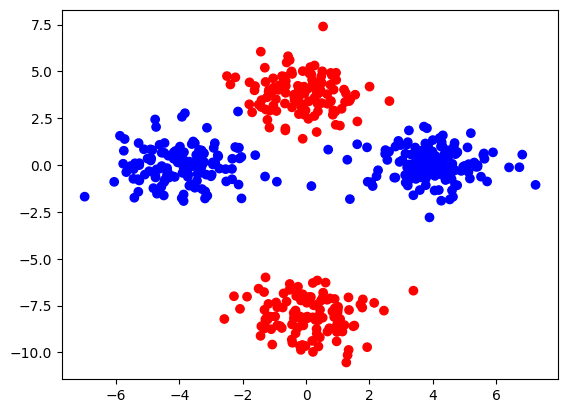

In [121]:
predictions = func_model.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=predictions[:,0]>0.5, cmap='bwr')

# Congratulations...
... you've trained a nonlinear classifier with TensorFlow and Keras using the sequential and the functional APIs!